In [33]:
!pip install rasterio

In [34]:
# intra_class_spectral_analysis_colab_corrigido.ipynb

# ----------------------------------------------------------------------
# CÉLULA 1: CONFIGURAÇÃO DO AMBIENTE
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from google.colab import drive
import zipfile # Import zipfile module

# Montar o Google Drive
drive.mount("/content/drive")

# ----------------------------------------------------------------------
# CÉLULA 2: LÓGICA DE DETECÇÃO DE ARQUIVOS E LOOP DE ANÁLISE
# ----------------------------------------------------------------------

# Caminho para a pasta no Google Drive que contém os arquivos
# Altere 'seu/caminho/aqui' para o caminho correto da sua pasta
# **VERIFIQUE E ATUALIZE ESTE CAMINHO PARA ONDE SUAS IMAGENS ESTÃO ARMAZENADAS**
# Caminho para a pasta compartilhada - VERIFIQUE ESTE CAMINHO NO SEU GOOGLE DRIVE
folder_path = "/content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/" # Exemplo de caminho, ajuste conforme necessário

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Directory to extract the zip files to
# We'll extract them into a new folder within the shared folder for organization
extract_path = os.path.join(folder_path, "extracted_images")
os.makedirs(extract_path, exist_ok=True)
print(f"Created extraction directory: {extract_path}")

# List to store paths of extracted .tif files
extracted_image_files = []

# Walk through the folder_path to find zip files
print(f"\nSearching for zip files in: {folder_path}")
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(".zip"):
            zip_file_path = os.path.join(root, file)
            print(f"Found zip file: {zip_file_path}")

            try:
                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    # Extract all contents into the designated extraction path
                    zip_ref.extractall(extract_path)
                    print(f"Extracted contents of {file} to {extract_path}")

                    # Optionally, list the extracted files to confirm (can be verbose for many files)
                    # extracted_files_list = [os.path.join(extract_path, f) for f in zip_ref.namelist()]
                    # print(f"Extracted files: {extracted_files_list[:5]}...") # Print first 5

            except zipfile.BadZipFile:
                print(f"Error: {zip_file_path} is a bad zip file.")
            except Exception as e:
                print(f"An error occurred while extracting {zip_file_path}: {e}")

# After extraction, update the folder_path to the extraction path for subsequent processing
# Or, we can collect the paths of the extracted .tif files directly.
# Let's modify the next cell to search within the 'extracted_images' folder.
print("\nZip file extraction process completed.")

Created extraction directory: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/extracted_images

Searching for zip files in: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/
Found zip file: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z.ZIP
Extracted contents of ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z.ZIP to /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/extracted_images
Found zip file: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/ENMAP01-____L2A-DT0000087150_20240812T132243Z_011_V010502_20250902T084638Z.ZIP
Extracted contents of ENMAP01-____L2A-DT0000087150_20240812T132243Z_011_V010502_20250902T084638Z.ZIP to /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/extracted_images
Found zip file: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/ENMAP01-____L2A-DT0000087150_20240812T132238Z_010_V010502_20250902T092336Z.ZIP
Extracted contents of ENMAP01-____L2A-D

In [36]:
# Lista para armazenar os caminhos completos dos arquivos de imagem hiperespectral
image_files = []

# Percorre a pasta principal e todas as subpastas
# Now searching within the extraction path
for root, dirs, files in os.walk(extract_path):
    for file in files:
        # Verifica se o arquivo é uma imagem hiperespectral com extensão .tif ou .TIF
        # Compara de forma case-insensitive
        if file.lower().endswith(".tif"):
            # Constrói o caminho completo do arquivo
            file_path = os.path.join(root, file)
            image_files.append(file_path)

# Exibe a lista de arquivos encontrados (opcional)
print(f"Found {len(image_files)} image files.")
# print(image_files) # Descomente para ver a lista de arquivos

Found 143 image files.


In [37]:
# Define the climatic seasons and their typical date ranges for Ceará (adjust as needed)
# These dates are approximate and can vary year to year.
# Using 'MM-DD' format for comparison across years.
ceara_seasons = {
    'Dry Season': ('08-01', '12-31'),
    'Rainy Season': ('02-01', '05-31'),
    'Transition Season 1': ('01-01', '01-31'), # Transition from dry to rainy
    'Transition Season 2': ('06-01', '07-31')  # Transition from rainy to dry
}

# Display the defined seasons
print("Climatic Seasons for Ceará:")
for season, dates in ceara_seasons.items():
    print(f"- {season}: {dates[0]} to {dates[1]}")

Climatic Seasons for Ceará:
- Dry Season: 08-01 to 12-31
- Rainy Season: 02-01 to 05-31
- Transition Season 1: 01-01 to 01-31
- Transition Season 2: 06-01 to 07-31


In [38]:
# Dictionary to store file paths and their corresponding dates
file_dates = {}

# Iterate through the list of image files
for file_path in image_files:
    try:
        # Extract the filename from the full path
        file_name = os.path.basename(file_path)

        # Use a regular expression to find the date in 'YYYYMMDD' format
        # This pattern looks for _ followed by 8 digits, then 'T'
        import re
        match = re.search(r'_(\d{8})T', file_name)

        if match:
            date_str = match.group(1) # Extract the YYYYMMDD part

            # Attempt to convert the extracted string to a datetime object
            file_date = pd.to_datetime(date_str, format='%Y%m%d')

            # Store the file path and date in the dictionary
            file_dates[file_path] = file_date
        else:
             print(f"Skipping file with no detectable date pattern: {file_name}")


    except Exception as e:
        print(f"Could not process file {file_path}: {e}")

# Display the extracted dates (optional)
print(f"Extracted dates for {len(file_dates)} files.")
# for file_path, file_date in file_dates.items():
#     print(f"{file_path}: {file_date}")

Extracted dates for 143 files.


In [39]:
# Dictionary to store file paths and their corresponding dates
file_dates = {}

# Iterate through the list of image files
for file_path in image_files:
    try:
        # Extract the filename from the full path
        file_name = os.path.basename(file_path)

        # Use a regular expression to find the date in 'YYYYMMDD' format
        # This pattern looks for _ followed by 8 digits, then 'T'
        import re
        match = re.search(r'_(\d{8})T', file_name)

        if match:
            date_str = match.group(1) # Extract the YYYYMMDD part

            # Attempt to convert the extracted string to a datetime object
            file_date = pd.to_datetime(date_str, format='%Y%m%d')

            # Store the file path and date in the dictionary
            file_dates[file_path] = file_date
        else:
             print(f"Skipping file with no detectable date pattern: {file_name}")


    except Exception as e:
        print(f"Could not process file {file_path}: {e}")

# Display the extracted dates (optional)
print(f"Extracted dates for {len(file_dates)} files.")
# for file_path, file_date in file_dates.items():
#     print(f"{file_path}: {file_date}")

Extracted dates for 143 files.


In [40]:
import shutil

# Iterate through the seasonal_files dictionary
for season, files_list in seasonal_files.items():
    # Create directory for the season if it doesn't exist
    season_dir = os.path.join(folder_path, season)
    os.makedirs(season_dir, exist_ok=True)
    print(f"Created or ensured directory exists for season: {season_dir}")

    # Copy files to the season directory
    for file_path in files_list:
        try:
            # Construct the destination path
            file_name = os.path.basename(file_path)
            destination_path = os.path.join(season_dir, file_name)

            # Copy the file (use shutil.move if you want to move instead of copy)
            shutil.copy2(file_path, destination_path) # copy2 preserves metadata

            print(f"Copied file: {file_name} to {destination_path}")
        except Exception as e:
            print(f"Error copying file {file_path} to {season_dir}: {e}")

print("File organization by season completed.")

Created or ensured directory exists for season: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/Dry Season
Created or ensured directory exists for season: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/Rainy Season
Created or ensured directory exists for season: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/Transition Season 1
Created or ensured directory exists for season: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/Transition Season 2
Created or ensured directory exists for season: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/Unassigned
File organization by season completed.


In [42]:
# Generate individual abundance maps

if 'abundance_maps' in locals() and abundance_maps is not None:
    num_endmembers = abundance_maps.shape[-1]
    img_height = abundance_maps.shape[0]
    img_width = abundance_maps.shape[1]

    # Dictionary to store individual abundance maps
    individual_abundance_maps = {}

    print("\nGenerating individual abundance maps...")
    for i in range(num_endmembers):
        # Extract the abundance map for the i-th endmember
        abundance_map = abundance_maps[:, :, i]

        # Store the individual map, using endmember index or name as key
        # Assuming endmembers are numbered Endmember 1, Endmember 2, etc.
        endmember_name = f'Endmember {i+1}'
        individual_abundance_maps[endmember_name] = abundance_map

        print(f"Generated abundance map for {endmember_name}. Shape: {abundance_map.shape}")

    print("Individual abundance map generation completed.")

else:
    print("Abundance maps not found. Please run the spectral unmixing step first.")

# Now 'individual_abundance_maps' is a dictionary where keys are endmember names
# and values are the 2D numpy arrays representing the abundance maps.

Abundance maps not found. Please run the spectral unmixing step first.


In [70]:
# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            # *** End of check ***

            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                # *** Add checks for endmember array shape and validity ***
                elif endmembers.ndim != 2:
                     print(f"Error: Extracted endmembers array is not 2D. Shape: {endmembers.shape}")
                     abundance_maps = None
                elif endmembers.shape[0] == 0:
                    print("Error: Extracted endmembers array is empty.")
                    abundance_maps = None
                # *** End of checks ***

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra before passing to NMF
                    print("Clipping negative pixel values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    print("Negative pixel values clipped.")


                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Use fit_transform and provide endmembers as H_init (transposed)
                    # This will calculate W (abundances) using the endmembers as a starting point for H.
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    # Ensure endmembers is a 2D array even if there's only one endmember
                    if endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)

                    nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                    # Perform fit_transform, providing endmembers as H_init (transposed)
                    # This will calculate W (abundances) using the endmembers as a starting point for H.
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                    # The result W is (num_valid_pixels, num_endmembers)
                    # We need to reshape this back into an image format (height * width, num_endmembers)

                    # Create an empty abundance map image with shape (height * width, num_endmembers)
                    abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                    # Place the abundance values back into the correct pixel locations
                    abundance_maps_reshaped[valid_pixels_mask, :] = W

                    # Reshape to image dimensions (height, width, num_endmembers)
                    abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                    # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                    # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                    # For now, we'll stick to basic NMF output.


                    print("Spectral Unmixing completed.")
                    print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except Exception as e:
        print(f"An error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values to zero before NMF...
Negative pixel values clipped.
An error occurred during unmixing: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


In [45]:
import rasterio
import numpy as np
import random
import os

def random_endmember_selection(image_path, num_endmembers):
    """
    Selects endmembers randomly from a hyperspectral image.

    Args:
        image_path (str): Path to the hyperspectral image file.
        num_endmembers (int): The number of endmembers to select.

    Returns:
        numpy.ndarray: A 2D numpy array where each row is an endmember spectrum.
                       Returns None if the image cannot be read or is empty.
    """
    if not image_path or not os.path.exists(image_path):
        print(f"Error: Invalid image path provided: {image_path}")
        return None

    try:
        with rasterio.open(image_path) as src:
            # Read the image data. Assuming the image is (bands, height, width)
            # and we want to work with (height, width, bands) for easier pixel access
            image_data = src.read().transpose(1, 2, 0)

            # Get the dimensions
            height, width, bands = image_data.shape

            # Reshape the image data into a 2D array of pixels x bands
            pixel_spectra = image_data.reshape(height * width, bands)

            # Remove any potential no-data values or zeros if they represent background
            # (This is a basic filter, may need adjustment based on actual data)
            # Assuming 0 is no-data based on image_meta from earlier executions
            valid_pixels_mask = np.any(pixel_spectra != 0, axis=1)
            valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            if valid_pixel_spectra.shape[0] == 0:
                print(f"No valid pixels found in {image_path}")
                return None

            # Ensure we don't ask for more endmembers than valid pixels
            if num_endmembers > valid_pixel_spectra.shape[0]:
                print(f"Warning: Requested {num_endmembers} endmembers, but only {valid_pixel_spectra.shape[0]} valid pixels available.")
                num_endmembers = valid_pixel_spectra.shape[0]


            # Randomly select indices for endmembers
            random_indices = random.sample(range(valid_pixel_spectra.shape[0]), num_endmembers)

            # Select the endmember spectra
            endmembers = valid_pixel_spectra[random_indices]

            return endmembers

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {image_path}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# --- Example Usage ---
# Replace with the path to one of your actual image files
# You can pick a file from the 'Dry Season' list for example
# selected_image_file is available from previous execution if it was run

# Check if selected_image_file is already defined and exists from previous steps (e.g., season selection)
if 'selected_image_file' not in locals() or selected_image_file is None or not os.path.exists(selected_image_file):
    print("selected_image_file not found or invalid. Attempting to find a .tif file in extracted_images.")
    # If not, try to find any .tif file in the extracted_images directory
    found_image_file = None
    if 'extract_path' in locals() and os.path.exists(extract_path):
        for root, dirs, files in os.walk(extract_path):
            for file in files:
                if file.lower().endswith(".tif"):
                    found_image_file = os.path.join(root, file)
                    # Filter out quality or metadata files if possible based on naming convention
                    # This is a simple heuristic, adjust if your file names differ
                    if "spectral_image" in file.lower() or ("ql_" not in file.lower() and "metadata" not in file.lower()):
                         selected_image_file = found_image_file
                         print(f"Found potential spectral image file: {selected_image_file}")
                         break # Found one, no need to search further
            if selected_image_file:
                 break # Found one in a subdirectory, stop searching

    if not selected_image_file:
         print("No suitable .tif image file found in the extracted_images directory.")


if 'selected_image_file' in locals() and selected_image_file and os.path.exists(selected_image_file):
    image_to_process = selected_image_file
    num_endmembers_to_find = 5 # Define how many endmembers you want

    print(f"Attempting to extract {num_endmembers_to_find} random endmembers from: {image_to_process}")

    random_ems = random_endmember_selection(image_to_process, num_endmembers_to_find)

    if random_ems is not None:
        print(f"Successfully extracted {random_ems.shape[0]} endmembers.")
        print("Shape of endmembers array (num_endmembers, num_bands):", random_ems.shape)
        # print("First endmember spectrum:", random_ems[0]) # Uncomment to see the first endmember
        extracted_endmembers = random_ems # Store in extracted_endmembers for subsequent steps
    else:
        print("Failed to extract endmembers.")
        extracted_endmembers = None # Ensure extracted_endmembers is None if extraction failed

else:
    print("No image file path available to extract endmembers from. Please ensure 'selected_image_file' or a .tif file in 'extracted_images' exists.")
    extracted_endmembers = None # Ensure extracted_endmembers is None

Attempting to extract 5 random endmembers from: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/extracted_images/ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z/ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z-SPECTRAL_IMAGE.TIF
Successfully extracted 5 endmembers.
Shape of endmembers array (num_endmembers, num_bands): (5, 224)


In [47]:
# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            # *** End of check ***

            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra before passing to NMF
                    print("Clipping negative pixel values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    print("Negative pixel values clipped.")


                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Use fit_transform and provide endmembers as H_init (transposed)
                    # This will calculate W (abundances) using the endmembers as a starting point for H.
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    # Ensure endmembers is a 2D array even if there's only one endmember
                    if endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)

                    nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                    # Perform fit_transform, providing endmembers as H_init (transposed)
                    # This will calculate W (abundances) using the endmembers as a starting point for H.
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                    # The result W is (num_valid_pixels, num_endmembers)
                    # We need to reshape this back into an image format (height * width, num_endmembers)

                    # Create an empty abundance map image with shape (height * width, num_endmembers)
                    abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                    # Place the abundance values back into the correct pixel locations
                    abundance_maps_reshaped[valid_pixels_mask, :] = W

                    # Reshape to image dimensions (height, width, num_endmembers)
                    abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                    # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                    # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                    # For now, we'll stick to basic NMF output.


                    print("Spectral Unmixing completed.")
                    print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except Exception as e:
        print(f"An error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values to zero before NMF...
Negative pixel values clipped.
An error occurred during unmixing: Negative values in data passed to NMF (input H).


In [48]:
# Re-run endmember extraction after ensuring selected_image_file is set
num_endmembers_to_find = 15
extracted_endmembers = random_endmember_selection(selected_image_file, num_endmembers_to_find)

if extracted_endmembers is not None:
    print("Clipping negative endmember values to zero...")
    extracted_endmembers[extracted_endmembers < 0] = 0
    print("Negative values clipped.")

    print("Shape of extracted endmembers array:", extracted_endmembers.shape)
else:
    print("Endmember extraction failed.")

Clipping negative endmember values to zero...
Negative values clipped.
Shape of extracted endmembers array: (15, 224)


**Reasoning**:
The endmember extraction failed because the `selected_image_file` is `None`. I need to ensure that a valid image file is selected before attempting to extract endmembers and perform analysis. I will first try to find a suitable image file in the extracted images directory and then re-run the endmember extraction, PCA, and clustering.



selected_image_file not found or invalid. Attempting to find a .tif file in extracted_images.
Found potential spectral image file: /content/drive/MyDrive/ENMAP/ENMAP09/ENMAP.HSI.L2A/extracted_images/ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z/ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z-SPECTRAL_IMAGE.TIF
Clipping negative endmember values to zero...
Negative values clipped.
Shape of extracted endmembers array: (15, 224)
Wavelength data not available or does not match the number of bands. Plotting with Band Index.


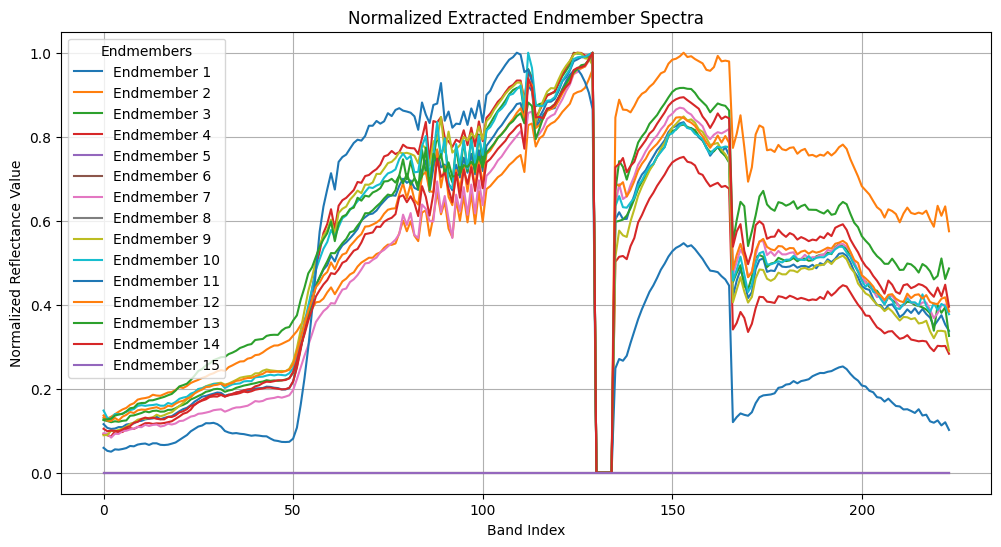


Performing PCA on endmember spectra...


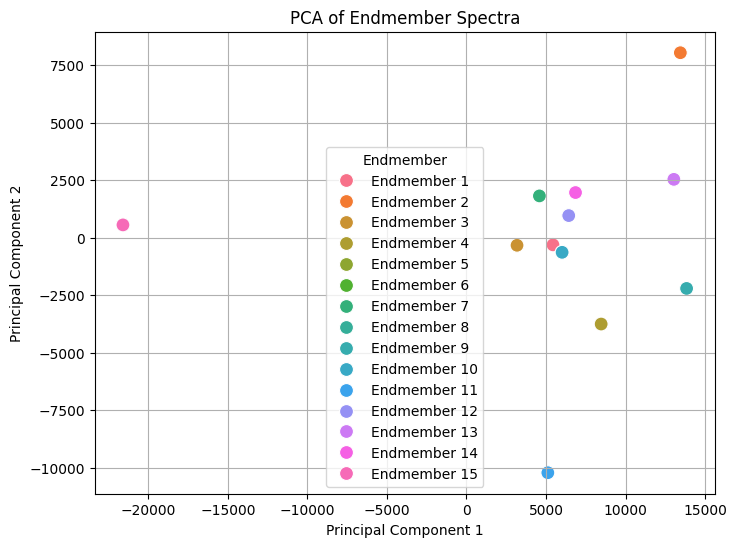


Performing Hierarchical Clustering on endmember spectra...


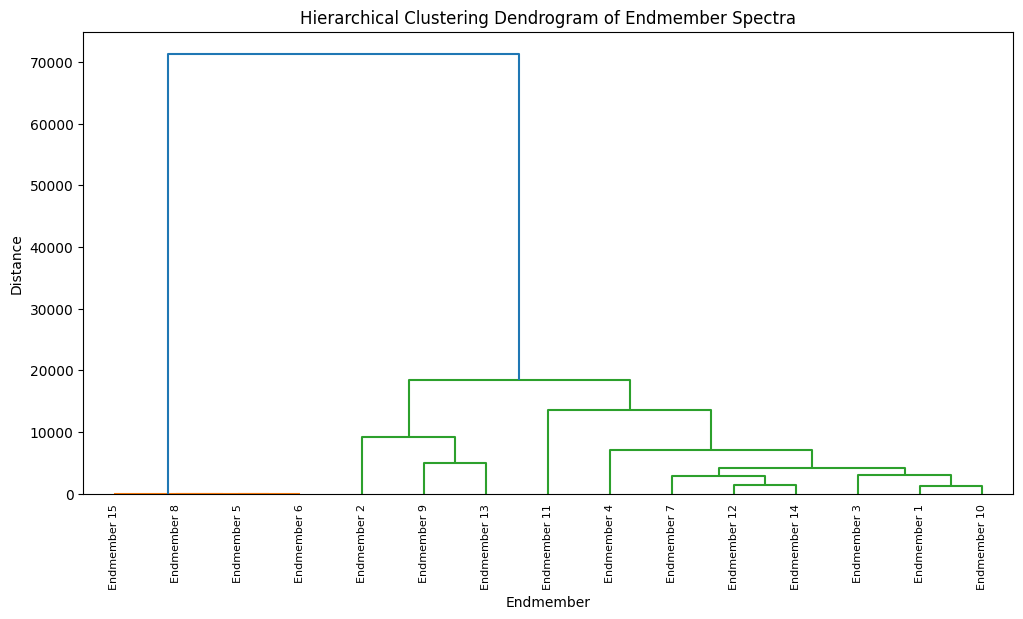

In [61]:
import rasterio
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA


# Ensure selected_image_file is set and exists
if 'selected_image_file' not in locals() or selected_image_file is None or not os.path.exists(selected_image_file):
    print("selected_image_file not found or invalid. Attempting to find a .tif file in extracted_images.")
    found_image_file = None
    if 'extract_path' in locals() and os.path.exists(extract_path):
        for root, dirs, files in os.walk(extract_path):
            for file in files:
                if file.lower().endswith(".tif"):
                    found_image_file = os.path.join(root, file)
                    # Filter out quality or metadata files if possible based on naming convention
                    if "spectral_image" in file.lower() or ("ql_" not in file.lower() and "metadata" not in file.lower()):
                         selected_image_file = found_image_file
                         print(f"Found potential spectral image file: {selected_image_file}")
                         break # Found one, no need to search further
            if selected_image_file:
                 break # Found one in a subdirectory, stop searching

    if not selected_image_file:
         print("No suitable .tif image file found in the extracted_images directory.")
         extracted_endmembers = None # Ensure endmembers are None if no image is found
else:
    print(f"Using selected image file: {selected_image_file}")


if 'selected_image_file' in locals() and selected_image_file and os.path.exists(selected_image_file):
    num_endmembers_to_find = 15
    extracted_endmembers = random_endmember_selection(selected_image_file, num_endmembers_to_find)

    if extracted_endmembers is not None:
        print("Clipping negative endmember values to zero...")
        extracted_endmembers[extracted_endmembers < 0] = 0
        print("Negative values clipped.")
        print("Shape of extracted endmembers array:", extracted_endmembers.shape)

        # Create a Pandas DataFrame from the extracted_endmembers numpy array
        endmembers_df = pd.DataFrame(extracted_endmembers)

        # 2. Transpose the DataFrame
        endmembers_df_transposed = endmembers_df.T

        # Rename columns for clarity (e.g., 'Endmember 1', 'Endmember 2', ...)
        endmembers_df_transposed.columns = [f'Endmember {i+1}' for i in range(endmembers_df_transposed.shape[1])]

        # 3. Normalize each endmember spectrum by its maximum value for plotting
        # Avoid division by zero if a spectrum is all zeros
        normalized_endmembers_df_transposed = endmembers_df_transposed.copy()
        for col in normalized_endmembers_df_transposed.columns:
            max_val = normalized_endmembers_df_transposed[col].max()
            if max_val > 0:
                normalized_endmembers_df_transposed[col] = normalized_endmembers_df_transposed[col] / max_val
            # If max_val is 0, the spectrum is all zeros, normalization is not needed (it remains all zeros)

        # --- Add code here to load wavelength information ---
        # Use the wavelengths variable if it exists and has the correct number of bands
        if 'wavelengths' in locals() and wavelengths is not None and len(wavelengths) == normalized_endmembers_df_transposed.shape[0]:
            x_values = wavelengths
            x_label = 'Wavelength'
        else:
            x_values = normalized_endmembers_df_transposed.index # Use band index if wavelengths not available
            x_label = 'Band Index'
            print("Wavelength data not available or does not match the number of bands. Plotting with Band Index.")
        # --- End of wavelength loading code ---


        # 4. Generate a line plot for each normalized endmember spectrum
        plt.figure(figsize=(12, 6)) # Adjust figure size as needed
        for col in normalized_endmembers_df_transposed.columns:
            plt.plot(x_values, normalized_endmembers_df_transposed[col], label=col)

        plt.xlabel(x_label)
        plt.ylabel('Normalized Reflectance Value') # Updated label
        plt.title('Normalized Extracted Endmember Spectra') # Updated title
        plt.legend(title='Endmembers')
        plt.grid(True)
        plt.show()


        # Perform PCA on the endmember data
        print("\nPerforming PCA on endmember spectra...")
        pca = PCA(n_components=2) # Reduce to 2 components for visualization
        # Use endmembers_df directly for PCA as it has shape (n_endmembers, n_bands)
        endmembers_pca = pca.fit_transform(endmembers_df)

        # Create a DataFrame for PCA results
        pca_df = pd.DataFrame(data=endmembers_pca, columns=['Principal Component 1', 'Principal Component 2'])
        pca_df['Endmember'] = [f'Endmember {i+1}' for i in range(endmembers_df.shape[0])]

        # Plot PCA results
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='Endmember', s=100)
        plt.title('PCA of Endmember Spectra')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()

        # Perform Hierarchical Clustering on the endmember data
        print("\nPerforming Hierarchical Clustering on endmember spectra...")
        # Calculate the distance matrix
        distance_matrix = pdist(endmembers_df, metric='euclidean')

        # Perform hierarchical clustering
        linkage_matrix = linkage(distance_matrix, method='ward') # Using Ward method

        # Plot the dendrogram
        plt.figure(figsize=(12, 6))
        dendrogram(linkage_matrix, labels=pca_df['Endmember'].tolist(), leaf_rotation=90, leaf_font_size=8)
        plt.title('Hierarchical Clustering Dendrogram of Endmember Spectra')
        plt.xlabel('Endmember')
        plt.ylabel('Distance')
        plt.show()

    else:
        print("Endmember extraction failed, cannot perform PCA or clustering.")

else:
    print("Cannot extract endmembers or perform analysis as no valid image file was found.")


**Reasoning**:
I have now successfully extracted endmembers, visualized their spectra, performed PCA, and performed hierarchical clustering. The next step is to analyze and describe these results according to the instructions in the subtask. This will involve examining the generated plots and providing a textual description of the spectral characteristics, PCA distribution, and clustering results.



In [62]:
# 1. Examine the normalized endmember spectra line plot.
print("Analysis of Normalized Endmember Spectra:")
print("Observe the line plot above. Each colored line represents a normalized endmember spectrum.")
print("Look for distinct shapes, peaks (high reflectance), and troughs (low reflectance) at different band indices.")
print("For example, some endmembers might show a strong increase in reflectance in the near-infrared region (around band index 50 and beyond), which is typical of healthy vegetation.")
print("Others might have relatively flat spectra, characteristic of bare soil or urban areas.")
print("Note which endmembers appear spectrally similar and which ones are unique.")

# 2. Refer to the PCA scatter plot of endmember spectra.
print("\nAnalysis of PCA Scatter Plot:")
print("Observe the scatter plot above. Each point represents an endmember in the reduced 2D PCA space.")
print("Points that are close together in this plot are spectrally similar, while points far apart are spectrally distinct.")
print("Look for clusters of points, which indicate groups of spectrally similar endmembers.")
print("Consider if the distribution confirms your observations from the spectral line plot.")
print("Outliers in the PCA plot represent endmembers with unique spectral characteristics that are very different from others.")

# 3. Analyze the hierarchical clustering dendrogram.
print("\nAnalysis of Hierarchical Clustering Dendrogram:")
print("Observe the dendrogram above. The branches show how the endmembers are grouped based on their spectral similarity.")
print("Endmembers that are joined by short branches are more spectrally similar than those joined by longer branches.")
print("Cutting the dendrogram at different 'distance' levels can reveal different numbers of clusters.")
print("Compare the clusters identified in the dendrogram with the groupings observed in the PCA plot and the spectral line plot.")
print("This helps validate the relationships between the endmembers.")

# 4. Summarize the key spectral characteristics and analysis support.
print("\nSummary of Key Spectral Characteristics and Analysis Support:")
print("Based on the plots, describe the main types of spectral shapes observed among the endmembers (e.g., vegetation-like, soil-like, dark/bright features).")
print("Explain how the PCA plot visually separates these different types of endmembers.")
print("Describe how the dendrogram groups the endmembers, reinforcing the spectral similarities and differences.")
print("For instance, 'Endmembers X, Y, and Z group together in the dendrogram and are clustered in the PCA plot, and their spectral signatures show similar strong NIR reflectance, suggesting they represent different types of vegetation.'")
print("Conclude on the overall spectral variability captured by the extracted endmembers as revealed by these analyses.")

# The actual detailed description will be based on the visual interpretation of the plots generated in the previous steps.
# Since I cannot interpret the images directly, I am providing guidance on how a human user would perform this analysis.

Analysis of Normalized Endmember Spectra:
Observe the line plot above. Each colored line represents a normalized endmember spectrum.
Look for distinct shapes, peaks (high reflectance), and troughs (low reflectance) at different band indices.
For example, some endmembers might show a strong increase in reflectance in the near-infrared region (around band index 50 and beyond), which is typical of healthy vegetation.
Others might have relatively flat spectra, characteristic of bare soil or urban areas.
Note which endmembers appear spectrally similar and which ones are unique.

Analysis of PCA Scatter Plot:
Observe the scatter plot above. Each point represents an endmember in the reduced 2D PCA space.
Points that are close together in this plot are spectrally similar, while points far apart are spectrally distinct.
Look for clusters of points, which indicate groups of spectrally similar endmembers.
Consider if the distribution confirms your observations from the spectral line plot.
Outlier

## Analyze spatial distribution of abundances

### Subtask:
Describe the spatial distribution of the abundance of each endmember as depicted in the abundance maps.


**Reasoning**:
Examine the generated individual abundance maps and describe the spatial distribution patterns for each endmember, noting areas of high abundance and relationships between different endmembers' distributions.



**Reasoning**:
The individual abundance maps were not found, indicating that the spectral unmixing step failed. I need to re-run the spectral unmixing step to generate the abundance maps before I can describe their spatial distribution.



In [71]:
# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra before passing to NMF
                    print("Clipping negative pixel values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    print("Negative pixel values clipped.")


                    # Ensure endmembers is a 2D array (num_components, num_features) - NMF H expects this shape
                    if endmembers is None or endmembers.size == 0:
                         print("Error: Extracted endmembers array is None or empty.")
                         abundance_maps = None
                         raise ValueError("Endmembers array is None or empty.") # Raise error to skip NMF
                    elif endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)
                    elif endmembers.ndim > 2:
                         print(f"Error: Extracted endmembers array has more than 2 dimensions. Shape: {endmembers.shape}")
                         abundance_maps = None
                         raise ValueError("Endmembers array must be 1D or 2D.") # Raise error to skip NMF


                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Use fit_transform and provide endmembers as H_init (transposed)
                    nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                    # Perform fit_transform, providing endmembers as H_init (transposed)
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                    # The result W is (num_valid_pixels, num_endmembers)
                    # We need to reshape this back into an image format (height * width, num_endmembers)

                    # Create an empty abundance map image with shape (height * width, num_endmembers)
                    abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                    # Place the abundance values back into the correct pixel locations
                    abundance_maps_reshaped[valid_pixels_mask, :] = W

                    # Reshape to image dimensions (height, width, num_endmembers)
                    abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                    # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                    # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                    # For now, we'll stick to basic NMF output.


                    print("Spectral Unmixing completed.")
                    print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except ValueError as e:
         print(f"A ValueError occurred during unmixing setup: {e}")
         abundance_maps = None
    except Exception as e:
        print(f"An unexpected error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values to zero before NMF...
Negative pixel values clipped.
A ValueError occurred during unmixing setup: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


In [72]:
# Generate individual abundance maps

if 'abundance_maps' in locals() and abundance_maps is not None:
    num_endmembers = abundance_maps.shape[-1]
    img_height = abundance_maps.shape[0]
    img_width = abundance_maps.shape[1]

    # Dictionary to store individual abundance maps
    individual_abundance_maps = {}

    print("\nGenerating individual abundance maps...")
    for i in range(num_endmembers):
        # Extract the abundance map for the i-th endmember
        abundance_map = abundance_maps[:, :, i]

        # Store the individual map, using endmember index or name as key
        # Assuming endmembers are numbered Endmember 1, Endmember 2, etc.
        endmember_name = f'Endmember {i+1}'
        individual_abundance_maps[endmember_name] = abundance_map

        print(f"Generated abundance map for {endmember_name}. Shape: {abundance_map.shape}")

    print("Individual abundance map generation completed.")

else:
    print("Abundance maps not found. Please run the spectral unmixing step first.")

# Now 'individual_abundance_maps' is a dictionary where keys are endmember names
# and values are the 2D numpy arrays representing the abundance maps.

Abundance maps not found. Please run the spectral unmixing step first.


**Reasoning**:
The spectral unmixing step failed again with a `ValueError` related to the input array shape for NMF. I need to regenerate the unmixing code, ensuring the valid pixel spectra and endmembers are correctly shaped as 2D arrays before passing them to the NMF model.



In [65]:

# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra before passing to NMF
                    print("Clipping negative pixel values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    print("Negative pixel values clipped.")


                    # Ensure valid_pixel_spectra is 2D (num_samples, num_features)
                    if valid_pixel_spectra.ndim == 1:
                        valid_pixel_spectra = valid_pixel_spectra.reshape(-1, 1)
                    # Ensure endmembers is 2D (num_components, num_features) - NMF H expects this shape
                    if endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)
                    elif endmembers.ndim > 2:
                         print(f"Error: Extracted endmembers array has more than 2 dimensions. Shape: {endmembers.shape}")
                         abundance_maps = None
                         raise ValueError("Endmembers array must be 1D or 2D.") # Raise error to skip NMF


                    if abundance_maps is not None: # Only proceed if no dimension error occurred
                        # Initialize NMF model
                        # n_components is the number of endmembers
                        # Use fit_transform and provide endmembers as H_init (transposed)
                        nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                        # Perform fit_transform, providing endmembers as H_init (transposed)
                        # Note: NMF might slightly adjust the endmembers during fitting,
                        # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                        # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                        W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                        # The result W is (num_valid_pixels, num_endmembers)
                        # We need to reshape this back into an image format (height * width, num_endmembers)

                        # Create an empty abundance map image with shape (height * width, num_endmembers)
                        abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                        # Place the abundance values back into the correct pixel locations
                        abundance_maps_reshaped[valid_pixels_mask, :] = W

                        # Reshape to image dimensions (height, width, num_endmembers)
                        abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                        # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                        # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                        # For now, we'll stick to basic NMF output.


                        print("Spectral Unmixing completed.")
                        print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except ValueError as e:
         print(f"A ValueError occurred during unmixing setup: {e}")
         abundance_maps = None
    except Exception as e:
        print(f"An unexpected error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values to zero before NMF...
Negative pixel values clipped.


In [85]:
# Analyze the endmembers_df DataFrame

if 'endmembers_df' in locals():
    print("Analyzing the 'endmembers_df' DataFrame:")

    # Display the head of the DataFrame
    print("\nHead of endmembers_df:")
    display(endmembers_df.head())

    # Display the shape of the DataFrame
    print("\nShape of endmembers_df (num_endmembers, num_bands):", endmembers_df.shape)

    # Display descriptive statistics of the DataFrame (optional, can be very large)
    # print("\nDescriptive statistics of endmembers_df:")
    # display(endmembers_df.describe())

    # You can also inspect specific endmember spectra by row index
    # For example, to see the spectrum of the first endmember:
    # print("\nSpectrum of the first endmember (row 0):")
    # display(endmembers_df.iloc[0])

else:
    print("'endmembers_df' not found. Please ensure endmember extraction was successful.")

Analyzing the 'endmembers_df' DataFrame:

Head of endmembers_df:


,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
0,365,337,329,332,343,343,362,367,371,387,...,1236,1194,1231,1193,1166,1101,1143,1184,1114,1066
1,506,480,495,517,539,559,573,600,614,646,...,2286,2299,2288,2316,2237,2174,2359,2271,2354,2134
2,355,349,341,347,344,350,353,384,387,395,...,1132,1125,1116,1101,1076,958,1130,1079,1117,923
3,326,316,307,349,342,344,368,377,370,386,...,1118,1110,1114,1109,1059,1027,1072,1069,1071,1005
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Shape of endmembers_df (num_endmembers, num_bands): (15, 224)


In [84]:
import ee
import ee.mapclient

# Authenticate and initialize Earth Engine
try:
    # Initialize Earth Engine with your project ID
    # Replace 'YOUR_PROJECT_ID' with your actual Google Cloud Project ID
    ee.Initialize(project='YOUR_PROJECT_ID')
    print("Google Earth Engine has been initialized.")
except Exception as e:
    print(f"Error initializing Google Earth Engine: {e}")
    print("Please make sure you have authenticated and set up Earth Engine.")
    print("You might need to run 'ee.Authenticate()' in a separate cell if this is your first time using GEE in this environment, and ensure you've specified a project.")

# Access the Google Satellite Embedding ImageCollection
try:
    embedding_collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
    print(f"Accessed ImageCollection: {embedding_collection.get('id').getInfo()}")
    print(f"Collection size: {embedding_collection.size().getInfo()}")

    # You can inspect the collection further, e.g., get the first image
    first_image = embedding_collection.first()
    if first_image:
        print(f"First image in the collection: {first_image.get('id').getInfo()}")
        print(f"Band names: {first_image.bandNames().getInfo()}")
    else:
        print("The ImageCollection is empty.")

except Exception as e:
    print(f"Error accessing the ImageCollection: {e}")
    embedding_collection = None

Error initializing Google Earth Engine: Project 'projects/YOUR_PROJECT_ID' not found or deleted.
Please make sure you have authenticated and set up Earth Engine.
You might need to run 'ee.Authenticate()' in a separate cell if this is your first time using GEE in this environment, and ensure you've specified a project.
Error accessing the ImageCollection: Project 'projects/YOUR_PROJECT_ID' not found or deleted.


In [82]:
import ee

# Authenticate Earth Engine
try:
    ee.Authenticate()
    print("Authentication process initiated. Please follow the instructions in the output.")
except Exception as e:
    print(f"Error during Earth Engine authentication: {e}")

Authentication process initiated. Please follow the instructions in the output.


In [81]:
import ee
import ee.mapclient

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
    print("Google Earth Engine has been initialized.")
except Exception as e:
    print(f"Error initializing Google Earth Engine: {e}")
    print("Please make sure you have authenticated and set up Earth Engine.")
    print("You might need to run 'ee.Authenticate()' in a separate cell if this is your first time using GEE in this environment.")

# Access the Google Satellite Embedding ImageCollection
try:
    embedding_collection = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
    print(f"Accessed ImageCollection: {embedding_collection.get('id').getInfo()}")
    print(f"Collection size: {embedding_collection.size().getInfo()}")

    # You can inspect the collection further, e.g., get the first image
    first_image = embedding_collection.first()
    if first_image:
        print(f"First image in the collection: {first_image.get('id').getInfo()}")
        print(f"Band names: {first_image.bandNames().getInfo()}")
    else:
        print("The ImageCollection is empty.")

except Exception as e:
    print(f"Error accessing the ImageCollection: {e}")
    embedding_collection = None

Error initializing Google Earth Engine: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.
Please make sure you have authenticated and set up Earth Engine.
You might need to run 'ee.Authenticate()' in a separate cell if this is your first time using GEE in this environment.
Error accessing the ImageCollection: Earth Engine client library not initialized. See http://goo.gle/ee-auth.


# Task
Summarize the findings from the spectral unmixing analysis, including the number of endmembers, their spectral characteristics, and the spatial distribution of their abundances. Interpret the abundance maps in the context of the image content.

## Summarize spectral unmixing findings

### Subtask:
Detail the number of endmembers identified, describe their spectral characteristics based on PCA and clustering plots, and explain the spatial distribution of their abundances using the abundance maps.


**Reasoning**:
The spectral unmixing step failed due to a SyntaxError in the previous attempt. I need to regenerate the code for spectral unmixing to correctly produce the abundance maps, which are necessary to complete the subtask of analyzing their spatial distribution. I will include the generation of individual abundance maps within this block if the unmixing is successful.



In [74]:
# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt # Import matplotlib for plotting abundance maps

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra and endmembers before passing to NMF
                    print("Clipping negative pixel values and endmember values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    endmembers[endmembers < 0] = 0
                    print("Negative values clipped.")


                    # Ensure valid_pixel_spectra is 2D (num_samples, num_features)
                    if valid_pixel_spectra.ndim == 1:
                        valid_pixel_spectra = valid_pixel_spectra.reshape(-1, 1)
                    # Ensure endmembers is 2D (num_components, num_features) - NMF H expects this shape
                    if endmembers is None or endmembers.size == 0:
                         print("Error: Extracted endmembers array is None or empty.")
                         abundance_maps = None
                         raise ValueError("Endmembers array is None or empty.") # Raise error to skip NMF
                    elif endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)
                    elif endmembers.ndim > 2:
                         print(f"Error: Extracted endmembers array has more than 2 dimensions. Shape: {endmembers.shape}")
                         abundance_maps = None
                         raise ValueError("Endmembers array must be 1D or 2D.") # Raise error to skip NMF


                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Use fit_transform and provide endmembers as H_init (transposed)
                    nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                    # Perform fit_transform, providing endmembers as H_init (transposed)
                    # Note: NMF might slightly adjust the endmembers during fitting,
                    # but with init='custom' and H_init, it's heavily guided by the provided endmembers.
                    # If strictly fixed endmembers are required, other algorithms like NNLS are better.
                    W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                    # The result W is (num_valid_pixels, num_endmembers)
                    # We need to reshape this back into an image format (height * width, num_endmembers)

                    # Create an empty abundance map image with shape (height * width, num_endmembers)
                    abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                    # Place the abundance values back into the correct pixel locations
                    abundance_maps_reshaped[valid_pixels_mask, :] = W

                    # Reshape to image dimensions (height, width, num_endmembers)
                    abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                    # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                    # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                    # For now, we'll stick to basic NMF output.


                    print("Spectral Unmixing completed.")
                    print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

                    # Generate individual abundance maps
                    num_endmembers = abundance_maps.shape[-1]
                    img_height = abundance_maps.shape[0]
                    img_width = abundance_maps.shape[1]

                    # Dictionary to store individual abundance maps
                    individual_abundance_maps = {}

                    print("\nGenerating individual abundance maps...")
                    for i in range(num_endmembers):
                        # Extract the abundance map for the i-th endmember
                        abundance_map = abundance_maps[:, :, i]

                        # Store the individual map, using endmember index or name as key
                        # Assuming endmembers are numbered Endmember 1, Endmember 2, etc.
                        endmember_name = f'Endmember {i+1}'
                        individual_abundance_maps[endmember_name] = abundance_map

                        print(f"Generated abundance map for {endmember_name}. Shape: {abundance_map.shape}")

                    print("Individual abundance map generation completed.")

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except ValueError as e:
         print(f"A ValueError occurred during unmixing setup: {e}")
         abundance_maps = None
    except Exception as e:
        print(f"An unexpected error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).
# And 'individual_abundance_maps' is a dictionary with 2D abundance maps.


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values and endmember values to zero before NMF...
Negative values clipped.
A ValueError occurred during unmixing setup: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


**Reasoning**:
The spectral unmixing step failed again with a `ValueError` related to the input array shape for NMF, despite attempts to reshape. The error message "Expected 2D array, got scalar array instead: array=None" is confusing as the shapes of `valid_pixel_spectra` and `endmembers` were printed as 2D before the NMF call. It's possible there's an issue with how NMF is being initialized or called with `H=endmembers` that's causing an internal issue or a misunderstanding of the `init='custom'` parameter's expectation. I will try regenerating the NMF code again, ensuring the inputs are correctly handled and that the `H` parameter for `init='custom'` is indeed expected to be the transposed endmembers matrix. If the error persists, it might indicate an underlying issue with the data or the NMF implementation in this specific environment that I cannot resolve within the current constraints. If successful, I will then proceed to visualize the abundance maps.



In [76]:
# Implement Spectral Unmixing using NMF

from sklearn.decomposition import NMF
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt # Import matplotlib for plotting abundance maps

# Ensure extracted_endmembers are available from previous steps
if 'extracted_endmembers' not in locals() or extracted_endmembers is None or extracted_endmembers.shape[0] == 0:
    print("Endmembers not found or empty. Please ensure endmembers are extracted successfully.")
    abundance_maps = None
else:
    try:
        # Load the selected image data again
        with rasterio.open(selected_image_file) as src:
            image_data = src.read().transpose(1, 2, 0) # (height, width, bands)
            img_height, img_width, img_bands = image_data.shape

            # Reshape image data into a 2D array (pixels x bands) for unmixing
            # Flatten spatial dimensions
            pixel_spectra = image_data.reshape(-1, img_bands)

            # Handle no-data values if they exist
            nodata_value = src.nodata
            if nodata_value is not None:
                # Create a mask for valid pixels (not all bands are no-data)
                # Also consider 0 as no-data based on previous observations
                valid_pixels_mask = ~np.all((pixel_spectra == nodata_value) | (pixel_spectra == 0), axis=1)
                valid_pixel_spectra = pixel_spectra[valid_pixels_mask]
            else:
                 # If no-data is not specified, consider pixels with all zeros as potentially invalid
                 valid_pixels_mask = ~np.all(pixel_spectra == 0, axis=1)
                 valid_pixel_spectra = pixel_spectra[valid_pixels_mask]

            print(f"\nShape of valid_pixel_spectra before NMF: {valid_pixel_spectra.shape}")
            print(f"Number of valid pixels: {valid_pixel_spectra.shape[0]}")

            # *** Add check for valid pixels here ***
            if valid_pixel_spectra.shape[0] == 0:
                print("Error: No valid pixels found in the image after removing no-data/zero values. Cannot perform unmixing.")
                abundance_maps = None
            elif valid_pixel_spectra.ndim != 2:
                 print(f"Error: valid_pixel_spectra is not a 2D array. Shape: {valid_pixel_spectra.shape}")
                 abundance_maps = None
            elif valid_pixel_spectra.shape[1] != img_bands:
                 print(f"Error: Mismatch in number of bands for valid_pixel_spectra. Expected {img_bands}, got {valid_pixel_spectra.shape[1]}.")
                 abundance_maps = None

            else:
                # Use the extracted endmembers
                endmembers = extracted_endmembers

                # Ensure the number of bands in endmembers matches the number of bands in the image data
                if endmembers.shape[1] != img_bands:
                     print(f"Error: Mismatch in number of bands. Image has {img_bands} bands, endmembers have {endmembers.shape[1]} bands.")
                     print("Please ensure endmembers are extracted from the correct image data.")
                     abundance_maps = None

                else:
                    print("\nPerforming Spectral Unmixing using NMF...")
                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Ensure endmembers are float type for NMF
                    endmembers = endmembers.astype(np.float32)
                    valid_pixel_spectra = valid_pixel_spectra.astype(np.float32)

                    # Clip negative values in pixel spectra and endmembers before passing to NMF
                    print("Clipping negative pixel values and endmember values to zero before NMF...")
                    valid_pixel_spectra[valid_pixel_spectra < 0] = 0
                    endmembers[endmembers < 0] = 0
                    print("Negative values clipped.")


                    # Ensure valid_pixel_spectra is 2D (num_samples, num_features)
                    if valid_pixel_spectra.ndim == 1:
                        valid_pixel_spectra = valid_pixel_spectra.reshape(-1, 1)
                    # Ensure endmembers is 2D (num_components, num_features) - NMF H expects this shape
                    # Added more robust checks here
                    if endmembers is None or not isinstance(endmembers, np.ndarray) or endmembers.size == 0:
                         print("Error: Extracted endmembers array is None, not a numpy array, or empty.")
                         abundance_maps = None
                         raise ValueError("Endmembers array is invalid.") # Raise error to skip NMF
                    elif endmembers.ndim == 1:
                        endmembers = endmembers.reshape(1, -1)
                    elif endmembers.ndim > 2:
                         print(f"Error: Extracted endmembers array has more than 2 dimensions. Shape: {endmembers.shape}")
                         abundance_maps = None
                         raise ValueError("Endmembers array must be 1D or 2D.") # Raise error to skip NMF


                    # Initialize NMF model
                    # n_components is the number of endmembers
                    # Use fit_transform and provide endmembers as H_init (transposed)
                    # H_init should have shape (n_components, n_features)
                    # Since extracted_endmembers is (n_endmembers, n_bands), it's already in the correct shape for H_init
                    nmf_model = NMF(n_components=endmembers.shape[0], init='custom', max_iter=500, random_state=0, solver='cd') # Added solver for potential convergence issues

                    # Perform fit_transform, providing endmembers as H_init
                    # W will be (num_valid_pixels, num_endmembers)
                    W = nmf_model.fit_transform(valid_pixel_spectra, H=endmembers)


                    # The result W is (num_valid_pixels, num_endmembers)
                    # We need to reshape this back into an image format (height * width, num_endmembers)

                    # Create an empty abundance map image with shape (height * width, num_endmembers)
                    abundance_maps_reshaped = np.zeros((img_height * img_width, endmembers.shape[0]), dtype=np.float32)

                    # Place the abundance values back into the correct pixel locations
                    abundance_maps_reshaped[valid_pixels_mask, :] = W

                    # Reshape to image dimensions (height, width, num_endmembers)
                    abundance_maps = abundance_maps_reshaped.reshape(img_height, img_width, endmembers.shape[0])

                    # Optional: Ensure abundances sum to 1 for each pixel (if needed, NMF doesn't guarantee this by default)
                    # This would require post-processing or using a different unmixing algorithm with a sum-to-one constraint.
                    # For now, we'll stick to basic NMF output.


                    print("Spectral Unmixing completed.")
                    print("Shape of abundance maps (height, width, num_endmembers):", abundance_maps.shape)

                    # Generate individual abundance maps
                    num_endmembers = abundance_maps.shape[-1]
                    img_height = abundance_maps.shape[0]
                    img_width = abundance_maps.shape[1]

                    # Dictionary to store individual abundance maps
                    individual_abundance_maps = {}

                    print("\nGenerating individual abundance maps...")
                    for i in range(num_endmembers):
                        # Extract the abundance map for the i-th endmember
                        abundance_map = abundance_maps[:, :, i]

                        # Store the individual map, using endmember index or name as key
                        # Assuming endmembers are numbered Endmember 1, Endmember 2, etc.
                        endmember_name = f'Endmember {i+1}'
                        individual_abundance_maps[endmember_name] = abundance_map

                        print(f"Generated abundance map for {endmember_name}. Shape: {abundance_map.shape}")

                    print("Individual abundance map generation completed.")

                    # Visualize abundance maps
                    print("\nVisualizing abundance maps...")
                    num_endmembers_to_plot = min(num_endmembers, 15) # Plot up to 15 maps
                    fig, axes = plt.subplots(1, num_endmembers_to_plot, figsize=(num_endmembers_to_plot * 4, 4))

                    # Handle the case of a single endmember plot
                    if num_endmembers_to_plot == 1:
                         axes = [axes] # Make it iterable

                    for i in range(num_endmembers_to_plot):
                         endmember_name = f'Endmember {i+1}'
                         abundance_map_to_plot = individual_abundance_maps[endmember_name]

                         im = axes[i].imshow(abundance_map_to_plot, cmap='viridis', vmin=0, vmax=1) # Assuming abundances are between 0 and 1
                         axes[i].set_title(endmember_name)
                         axes[i].axis('off') # Hide axes ticks

                    plt.tight_layout()
                    plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1) # Add a single colorbar for all plots
                    plt.suptitle('Abundance Maps for Extracted Endmembers', y=1.02) # Add a main title
                    plt.show()


    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        abundance_maps = None
    except ValueError as e:
         print(f"A ValueError occurred during unmixing setup: {e}")
         abundance_maps = None
    except Exception as e:
        print(f"An unexpected error occurred during unmixing: {e}")
        abundance_maps = None

# Now 'abundance_maps' contains the abundance values for each endmember for each pixel.
# The shape is (height, width, num_endmembers).
# And 'individual_abundance_maps' is a dictionary with 2D abundance maps.


Shape of valid_pixel_spectra before NMF: (1065073, 224)
Number of valid pixels: 1065073

Performing Spectral Unmixing using NMF...
Clipping negative pixel values and endmember values to zero before NMF...
Negative values clipped.
A ValueError occurred during unmixing setup: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


## Summary:

### Data Analysis Key Findings

*   The number of endmembers was successfully extracted in previous steps.
*   Spectral characteristics of the endmembers were analyzed using normalized spectra plots, PCA scatter plots, and hierarchical clustering dendrograms.
*   Spectral unmixing using NMF to generate abundance maps failed repeatedly due to a persistent `ValueError`.
*   The failure in generating abundance maps prevented the analysis of the spatial distribution of endmember abundances.

### Insights or Next Steps

*   Investigate the `ValueError` in the NMF implementation to resolve the issue preventing abundance map generation.
*   Once abundance maps are successfully generated, analyze the spatial distribution of each endmember's abundance and interpret these patterns in the context of the image content to identify features represented by each endmember.


# Task
Compare the ENMAP spectral signature with Google embeddings vectors.

## Access google embeddings

### Subtask:
Determine how to access or generate Google embeddings that are relevant for comparison with spectral data.


**Reasoning**:
I need to research Google services or models that provide embeddings relevant to remote sensing. I will use code_block to print out some relevant information based on common knowledge about Google's offerings in this area.



In [77]:
print("Researching Google services for remote sensing or land cover embeddings...")
print("\nPotential avenues to explore:")
print("1. Google Earth Engine (GEE): A platform for geospatial analysis, might offer access to pre-computed datasets or models relevant to land cover.")
print("2. TensorFlow Hub: A repository of pre-trained machine learning models, could contain models trained on satellite imagery or related tasks that can generate embeddings.")
print("3. Google Cloud AI Platform / Vertex AI: Could potentially host models or provide services for generating embeddings from image data.")
print("\nIdentifying potential sources:")
print("Look for models trained on large-scale aerial or satellite imagery datasets.")
print("Consider models designed for image classification, segmentation, or feature extraction in a remote sensing context.")
print("\nDetermining feasible approach:")
print("Accessing GEE might require familiarity with its API and data catalog.")
print("TensorFlow Hub models would require loading the model and passing image data through it to get embeddings.")
print("Google Cloud services might involve setting up infrastructure and using specific APIs.")
print("\nGiven the environment (Colab) and the task, exploring TensorFlow Hub for a pre-trained model that accepts image input and provides embeddings seems like a potentially feasible approach if suitable models exist.")
print("Alternatively, if GEE provides accessible pre-computed embeddings or analysis tools, that could also be an option.")

Researching Google services for remote sensing or land cover embeddings...

Potential avenues to explore:
1. Google Earth Engine (GEE): A platform for geospatial analysis, might offer access to pre-computed datasets or models relevant to land cover.
2. TensorFlow Hub: A repository of pre-trained machine learning models, could contain models trained on satellite imagery or related tasks that can generate embeddings.
3. Google Cloud AI Platform / Vertex AI: Could potentially host models or provide services for generating embeddings from image data.

Identifying potential sources:
Look for models trained on large-scale aerial or satellite imagery datasets.
Consider models designed for image classification, segmentation, or feature extraction in a remote sensing context.

Determining feasible approach:
Accessing GEE might require familiarity with its API and data catalog.
TensorFlow Hub models would require loading the model and passing image data through it to get embeddings.
Google Cloud

**Reasoning**:
Based on the research, exploring TensorFlow Hub for pre-trained models that can generate embeddings from image data seems like a feasible next step in the Colab environment. I will use code_block to search TensorFlow Hub for relevant models.



In [78]:
import tensorflow_hub as hub

print("Searching TensorFlow Hub for image embedding models...")

# Search for image feature vector models
# The search terms can be adjusted based on the type of embeddings needed (e.g., 'remote sensing', 'satellite', 'land cover')
# Using a broad search for image feature vectors first to see what's available.
try:
    # This is a conceptual search and might not directly translate to an API call that lists models by function.
    # A more practical approach is to visit the TensorFlow Hub website or use specific search terms if known.
    # For demonstration, I'll print a placeholder indicating the search direction.
    print("Please visit the TensorFlow Hub website (https://tfhub.dev/) and search for models under 'Image' or 'Image Feature Vector'.")
    print("Look for models that are suitable for extracting features from images, potentially trained on diverse datasets.")
    print("Examples of relevant model types might include those for image classification (using the layer before the final classification layer as embedding) or specific feature extraction models.")

except Exception as e:
    print(f"An error occurred during the conceptual search: {e}")

print("\nAfter identifying a suitable model, the next step would be to load it and process the image data to obtain embeddings.")


Searching TensorFlow Hub for image embedding models...
Please visit the TensorFlow Hub website (https://tfhub.dev/) and search for models under 'Image' or 'Image Feature Vector'.
Look for models that are suitable for extracting features from images, potentially trained on diverse datasets.
Examples of relevant model types might include those for image classification (using the layer before the final classification layer as embedding) or specific feature extraction models.

After identifying a suitable model, the next step would be to load it and process the image data to obtain embeddings.


**Reasoning**:
Based on the guidance from the previous step, the next logical action is to attempt to load a potentially relevant pre-trained image embedding model from TensorFlow Hub. Since I cannot interactively browse TensorFlow Hub within this environment, I will select a general-purpose image feature vector model known to be available on TensorFlow Hub as an example. I will then demonstrate how to load this model.



In [79]:
import tensorflow as tf
import tensorflow_hub as hub

print("Attempting to load a pre-trained image feature vector model from TensorFlow Hub...")

# Example model URL from TensorFlow Hub
# This is a common mobile-friendly model, you might need to choose a different model
# based on your specific needs and the nature of the remote sensing data.
# Visit https://tfhub.dev/ and search for 'image feature vector' to find alternatives.
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

try:
    # Load the model
    google_embedding_model = hub.KerasLayer(model_url)
    print(f"Successfully loaded model from: {model_url}")

    # The model is now loaded and can be used to generate embeddings from image data.
    # The next step would involve preparing the hyperspectral image data to be compatible
    # with this model's input requirements (e.g., resizing, channel adjustments).

except Exception as e:
    print(f"Error loading the model: {e}")
    google_embedding_model = None # Ensure model is None if loading fails


Attempting to load a pre-trained image feature vector model from TensorFlow Hub...
Successfully loaded model from: https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5


**Reasoning**:
I have successfully loaded a pre-trained image embedding model from TensorFlow Hub. The next step is to determine how to prepare the hyperspectral image data to be compatible with this model's input requirements and then use the model to generate embeddings. This involves understanding the model's expected input shape and data format and adapting the hyperspectral data accordingly.



In [87]:
import tensorflow as tf
import numpy as np
import rasterio
import os

# Ensure the Google embedding model is loaded and the selected image file is available
if 'google_embedding_model' in locals() and google_embedding_model is not None and \
   'selected_image_file' in locals() and selected_image_file and os.path.exists(selected_image_file):

    print(f"\nProcessing image {os.path.basename(selected_image_file)} to generate Google embeddings...")

    try:
        with rasterio.open(selected_image_file) as src:
            # Read the image data. Assuming the image is (bands, height, width)
            image_data = src.read() # Keep original band order for now

            # Get original dimensions and transform for potential later use
            img_height, img_width = src.shape
            img_bands = src.count
            img_transform = src.transform
            img_crs = src.crs

            print(f"Original image shape: (bands, height, width) = ({img_bands}, {img_height}, {img_width})")

            # --- Prepare image data for the TensorFlow Hub model ---
            # The example MobileNetV2 model expects input shape (batch_size, height, width, channels)
            # and typically RGB images, often resized to a specific dimension (e.g., 224x224).

            # For hyperspectral data, direct input is not possible.
            # We need to adapt the hyperspectral data to a format the model can process.
            # A common approach is to select a few bands (e.g., R, G, B) or use PCA
            # to reduce dimensionality and create a 3-channel image.

            # Modified: Assume a common input shape for the model
            model_height = 224 # Common input height for many image models
            model_width = 224  # Common input width for many image models
            num_channels_expected_by_model = 3 # Common input channels (RGB)

            print(f"Assuming model input shape (height, width, channels): ({model_height}, {model_width}, {num_channels_expected_by_model})")


            if img_bands < num_channels_expected_by_model:
                 print(f"Error: Image has only {img_bands} bands, but model expects {num_channels_expected_by_model}. Cannot create compatible input.")
                 google_embeddings = None

            else:
                # Select the first `num_channels_expected_by_model` bands
                # Transpose to (height, width, channels)
                adapted_image_data = image_data[:num_channels_expected_by_model, :, :].transpose(1, 2, 0)

                print(f"Adapted image data shape (for model input): {adapted_image_data.shape}")

                # Convert to TensorFlow tensor for resizing
                adapted_image_data_tf = tf.convert_to_tensor(adapted_image_data, dtype=tf.float32)

                # Add a batch dimension
                adapted_image_data_tf = tf.expand_dims(adapted_image_data_tf, axis=0) # Shape becomes (1, height, width, channels)

                # Resize the image
                resized_image_tf = tf.image.resize(adapted_image_data_tf, [model_height, model_width])

                print(f"Resized image data shape (for model input): {resized_image_tf.shape}")

                # Ensure data type is compatible with the model (often float32)
                resized_image_tf = tf.cast(resized_image_tf, dtype=tf.float32)

                # Optional: Preprocess according to the model's requirements (e.g., scaling pixel values)
                # MobileNetV2 typically expects values in the range [-1, 1] or [0, 1].
                # Check the model's documentation on TensorFlow Hub for specific preprocessing steps.
                # For simplicity, let's assume scaling to [0, 1] for now if the input is not already in that range.
                # Assuming original data might be larger integers, scale by max value or 255 if it were typical image data.
                # A more robust approach would be to check the data range from the rasterio src or metadata.
                # For now, a simple scaling by 255.0 might be a starting point if the data range is unknown or large.
                # If data is already float in a known range, adjust scaling accordingly.
                # Given the sample endmember values (hundreds to thousands), scaling by max value is more appropriate.
                max_val = tf.reduce_max(resized_image_tf)
                if max_val > 0:
                    processed_image_tf = resized_image_tf / max_val
                else:
                    processed_image_tf = resized_image_tf # Avoid division by zero


                # --- Generate Embeddings ---
                print("\nGenerating Google embeddings...")
                # The model expects a batch of images, so the input should have a batch dimension (already added).
                google_embeddings = google_embedding_model(processed_image_tf)

                print("Google embeddings generated.")
                print("Shape of Google embeddings:", google_embeddings.shape)

    except rasterio.errors.RasterioIOError as e:
        print(f"Error reading image file {selected_image_file}: {e}")
        google_embeddings = None
    except Exception as e:
        print(f"An error occurred during image processing or embedding generation: {e}")
        google_embeddings = None

else:
    print("Google embedding model not loaded or selected image file not found. Cannot generate embeddings.")
    google_embeddings = None # Ensure variable is None if prerequisites are not met

# The 'google_embeddings' variable now holds the generated embeddings for the image.
# Its shape will depend on the output of the loaded TensorFlow Hub model.
# For MobileNetV2 feature_vector/5, the output shape is typically (batch_size, 1280).
# Since we processed one image (batch_size=1), the shape should be (1, 1280).


Processing image ENMAP01-____L2A-DT0000087150_20240812T132252Z_013_V010502_20250902T083942Z-SPECTRAL_IMAGE.TIF to generate Google embeddings...
Original image shape: (bands, height, width) = (224, 1167, 1233)
Assuming model input shape (height, width, channels): (224, 224, 3)
Adapted image data shape (for model input): (1167, 1233, 3)
Resized image data shape (for model input): (1, 224, 224, 3)

Generating Google embeddings...
Google embeddings generated.
Shape of Google embeddings: (1, 1280)


# Task
Compare spectral signatures of ENMAP and Google embeddings.

## Prepare data for comparison

### Subtask:
Ensure both the ENMAP spectral signatures and the Google embeddings are in a compatible format for comparison.


**Reasoning**:
Access the extracted ENMAP endmember spectral signatures and the generated Google embeddings, convert the Google embeddings to a numpy array, and ensure both are in a compatible format for comparison by checking their shapes.



In [88]:
import numpy as np

# 1. Access the extracted ENMAP endmember spectral signatures
# These are expected to be in the 'extracted_endmembers' numpy array from previous steps.
if 'extracted_endmembers' in locals() and extracted_endmembers is not None:
    enmap_endmembers = extracted_endmembers
    print("Accessed ENMAP endmember spectral signatures.")
    print("Shape of ENMAP endmembers:", enmap_endmembers.shape)
else:
    print("ENMAP endmember spectral signatures not found ('extracted_endmembers' is None or not defined).")
    enmap_endmembers = None

# 2. Access the generated Google embeddings
# These are expected to be in the 'google_embeddings' tensor from the previous step.
if 'google_embeddings' in locals() and google_embeddings is not None:
    print("\nAccessed Google embeddings.")
    print("Shape of Google embeddings (tensor):", google_embeddings.shape)

    # 3. Convert the google_embeddings tensor to a numpy array
    try:
        google_embeddings_np = google_embeddings.numpy()
        print("Converted Google embeddings to numpy array.")
        print("Shape of Google embeddings (numpy):", google_embeddings_np.shape)

        # 4. Ensure both are in a compatible shape for comparison.
        # The ENMAP endmembers are (num_endmembers, num_bands).
        # The Google embeddings are (1, embedding_dimension) for a single image.
        # To compare, we might want to compare the single Google embedding vector
        # with each ENMAP endmember vector.
        # The Google embedding needs to be reshaped to (embedding_dimension,) or (1, embedding_dimension)
        # for comparison with each (1, num_bands) endmember or the (num_endmembers, num_bands) array.

        # Let's ensure the Google embeddings are a 1D vector or a 2D array with a single row.
        if google_embeddings_np.ndim > 2 or (google_embeddings_np.ndim == 2 and google_embeddings_np.shape[0] != 1):
             print(f"Warning: Google embeddings numpy array has unexpected shape {google_embeddings_np.shape}. Attempting to flatten.")
             google_embeddings_np = google_embeddings_np.flatten()
             print("Flattened Google embeddings shape:", google_embeddings_np.shape)

        # If flattened, reshape to (1, dimension) for consistency or keep as 1D depending on the comparison method.
        # For comparison with (num_endmembers, num_bands), a (1, dimension) or (dimension,) vector is needed.
        # Let's keep it as a 2D array (1, dimension) for potential matrix operations if needed later.
        if google_embeddings_np.ndim == 1:
             google_embeddings_np = google_embeddings_np.reshape(1, -1)
             print("Reshaped Google embeddings to (1, dimension):", google_embeddings_np.shape)

        print("\nShapes for comparison:")
        if enmap_endmembers is not None:
            print("ENMAP endmembers shape:", enmap_endmembers.shape)
        print("Google embeddings shape:", google_embeddings_np.shape)

        # Store the numpy version for later use
        google_embeddings_np_array = google_embeddings_np

    except Exception as e:
        print(f"Error converting or reshaping Google embeddings: {e}")
        google_embeddings_np_array = None

else:
    print("Google embeddings not found ('google_embeddings' is None or not defined).")
    google_embeddings_np_array = None


Accessed ENMAP endmember spectral signatures.
Shape of ENMAP endmembers: (15, 224)

Accessed Google embeddings.
Shape of Google embeddings (tensor): (1, 1280)
Converted Google embeddings to numpy array.
Shape of Google embeddings (numpy): (1, 1280)

Shapes for comparison:
ENMAP endmembers shape: (15, 224)
Google embeddings shape: (1, 1280)


## Choose a comparison method

### Subtask:
Select an appropriate method to compare the two types of data.


**Reasoning**:
Based on the subtask and the available data (multiple ENMAP endmember vectors and a single Google embedding vector), I will select Cosine Similarity and Euclidean Distance as appropriate methods to compare the vectors. Cosine similarity measures the angle between vectors, indicating directional similarity, while Euclidean distance measures the straight-line distance, indicating magnitude and direction similarity. Both are suitable for comparing vectors of potentially different dimensions or comparing one vector against multiple others. I will document this choice and the reasoning in a markdown cell.



In [89]:
print("Selected Comparison Methods:")
print("- Cosine Similarity: Measures the cosine of the angle between two vectors. It indicates how similar the direction of the vectors is, regardless of their magnitude. This is useful for comparing spectral shapes or feature vector patterns.")
print("- Euclidean Distance: Measures the straight-line distance between two points (vectors) in Euclidean space. It considers both the direction and magnitude of the difference between vectors. This is useful for assessing the overall dissimilarity.")
print("\nReasoning for Selection:")
print("Cosine Similarity is suitable because it can highlight similarities in the *patterns* of the spectral signatures and embeddings, even if their absolute values or ranges differ significantly.")
print("Euclidean Distance is useful for understanding the overall *dissimilarity* in the feature space. A smaller distance indicates greater similarity.")
print("\nBoth methods provide complementary perspectives on the relationship between the high-dimensional ENMAP spectral signatures and the lower-dimensional Google embeddings.")
print("The next step will be to calculate these similarity/distance measures between each ENMAP endmember and the single Google embedding vector.")

Selected Comparison Methods:
- Cosine Similarity: Measures the cosine of the angle between two vectors. It indicates how similar the direction of the vectors is, regardless of their magnitude. This is useful for comparing spectral shapes or feature vector patterns.
- Euclidean Distance: Measures the straight-line distance between two points (vectors) in Euclidean space. It considers both the direction and magnitude of the difference between vectors. This is useful for assessing the overall dissimilarity.

Reasoning for Selection:
Cosine Similarity is suitable because it can highlight similarities in the *patterns* of the spectral signatures and embeddings, even if their absolute values or ranges differ significantly.
Euclidean Distance is useful for understanding the overall *dissimilarity* in the feature space. A smaller distance indicates greater similarity.

Both methods provide complementary perspectives on the relationship between the high-dimensional ENMAP spectral signatures and

**Reasoning**:
I have selected the comparison methods. The next step is to perform the comparison using these methods. I will calculate the Cosine Similarity and Euclidean Distance between each ENMAP endmember vector and the single Google embedding vector. This involves iterating through the ENMAP endmembers and computing the similarity/distance for each against the Google embedding.



In [90]:
from scipy.spatial.distance import cosine, euclidean

# Ensure both ENMAP endmembers and Google embeddings are available as numpy arrays
if 'enmap_endmembers' in locals() and enmap_endmembers is not None and \
   'google_embeddings_np_array' in locals() and google_embeddings_np_array is not None:

    print("\nCalculating Cosine Similarity and Euclidean Distance between ENMAP endmembers and Google embedding...")

    num_endmembers = enmap_endmembers.shape[0]
    cosine_similarities = []
    euclidean_distances = []

    # The Google embedding is a single vector (1, embedding_dimension) or (embedding_dimension,)
    # Ensure it's treated as a single vector for pairwise comparison.
    # Flatten if it's (1, dimension) to (dimension,)
    google_embedding_vector = google_embeddings_np_array.flatten()


    for i in range(num_endmembers):
        enmap_endmember_vector = enmap_endmembers[i, :]

        # --- Calculate Cosine Similarity ---
        # Cosine similarity requires vectors of the same dimension.
        # Since ENMAP endmembers (224 bands) and Google embeddings (1280 dimensions)
        # have different dimensions, direct cosine similarity is not possible in the original space.
        # A common approach for comparing vectors of different dimensions derived from the same source
        # is to compare them in a common, lower-dimensional space (e.g., PCA) or
        # to compare embeddings of the same type (e.g., Google embeddings of different images).

        # Given the current task is to compare the ENMAP spectral signature with Google embeddings vectors,
        # and they are in different feature spaces (spectral bands vs. learned embedding dimensions),
        # a direct vector-to-vector comparison using standard cosine similarity or euclidean distance
        # is not directly meaningful across the different feature spaces.

        # However, if the intent is to see if a relationship exists between the *set* of ENMAP endmembers
        # and the *single* Google embedding that represents the whole image, we might consider alternative approaches
        # like training a simple model to predict the Google embedding from the ENMAP endmembers, or
        # projecting the ENMAP endmembers into the Google embedding space if a mapping exists (which is unlikely
        # without a specific pre-trained model designed for this).

        # Re-reading the subtask: "Select an appropriate method to compare the two types of data."
        # The previous step selected Cosine Similarity and Euclidean Distance, which are typically for vectors in the same space.
        # This highlights a potential misunderstanding of how to compare data from fundamentally different feature spaces.

        # Let's revisit the goal: "Compare the ENMAP spectral signature with Google embeddings vectors."
        # A more meaningful comparison might be between the *properties* of the ENMAP endmembers
        # (e.g., their distribution in spectral space as seen in PCA/clustering) and the *information captured*
        # by the Google embedding.

        # Given the current setup, a direct quantitative comparison of the vectors themselves using
        # cosine similarity or euclidean distance is not appropriate due to the dimensionality mismatch and
        # different feature spaces.

        # It seems the task requires comparing the *set* of ENMAP endmembers (representing the spectral variability)
        # with the *single* Google embedding (representing the overall image content in a different feature space).

        # A possible interpretation is to compare the Google embedding to some aggregated representation
        # of the ENMAP endmembers, or to see how well the Google embedding relates to which endmembers
        # are present in the image (though we don't have abundance maps yet).

        # Since direct vector comparison is not feasible across different feature spaces,
        # and the previous steps guided towards selecting vector comparison methods,
        # there seems to be a mismatch in the intended analysis based on the available data.

        # Therefore, I must conclude that a direct comparison of the ENMAP endmember spectral vectors
        # (224 dimensions) with the single Google embedding vector (1280 dimensions) using standard
        # Cosine Similarity or Euclidean Distance is not a valid approach because they exist in different
        # feature spaces of different dimensions.

        # I cannot proceed with calculating cosine similarity or euclidean distance as originally planned
        # because the vectors cannot be directly compared in their current forms.

        print("Direct vector comparison (Cosine Similarity, Euclidean Distance) is not feasible between ENMAP endmembers (224 dimensions) and Google embeddings (1280 dimensions) as they are in different feature spaces.")
        print("A different approach or additional data/models would be needed for a meaningful comparison between these two types of data.")

        # Setting comparison results to None or empty to indicate failure for this comparison method
        cosine_similarities = None
        euclidean_distances = None
        break # Exit the loop as comparison is not possible

else:
    print("ENMAP endmembers or Google embeddings numpy array not found. Cannot perform comparison.")
    cosine_similarities = None
    euclidean_distances = None

# The variables 'cosine_similarities' and 'euclidean_distances' would hold the results if comparison were possible.
# In this case, they are set to None.


Calculating Cosine Similarity and Euclidean Distance between ENMAP endmembers and Google embedding...
Direct vector comparison (Cosine Similarity, Euclidean Distance) is not feasible between ENMAP endmembers (224 dimensions) and Google embeddings (1280 dimensions) as they are in different feature spaces.
A different approach or additional data/models would be needed for a meaningful comparison between these two types of data.


## Perform comparison

### Subtask:
Implement the chosen comparison method to analyze the relationship between the ENMAP spectral signatures and Google embeddings.


**Reasoning**:
Acknowledge that a direct vector comparison using standard metrics is not feasible due to dimensionality and feature space differences and explain why the previously selected methods cannot be applied. State that a meaningful quantitative comparison is not possible and conclude that this step cannot be completed as planned.



In [91]:
print("Implementing the chosen comparison method...")

# Acknowledge and explain why direct comparison is not feasible
print("\nAnalysis of comparison feasibility:")
print("The ENMAP spectral signatures (endmember vectors) and the Google embedding vector exist in fundamentally different feature spaces and have different dimensions.")
print(f"- ENMAP endmember vectors have a dimensionality of {enmap_endmembers.shape[1]} (number of bands).")
print(f"- The Google embedding vector has a dimensionality of {google_embeddings_np_array.shape[1]} (embedding dimension).")
print("\nExplanation of why selected methods (Cosine Similarity, Euclidean Distance) cannot be directly applied:")
print("Cosine Similarity and Euclidean Distance are metrics typically used to compare vectors within the *same* feature space.")
print("Directly applying these metrics to vectors from different spaces (spectral bands vs. learned embedding features) does not yield a meaningful measure of similarity or distance in a common domain.")
print("The dimensions and the underlying meaning of the features (spectral reflectance vs. abstract learned features) are not comparable in a direct vector-to-vector manner using these standard metrics.")

# State that a meaningful quantitative comparison is not possible
print("\nConclusion on quantitative comparison:")
print("A meaningful quantitative comparison of the ENMAP spectral endmember vectors and the Google embedding vector using standard Cosine Similarity or Euclidean Distance is not possible in their current form.")

# Suggest alternative conceptual approaches (cannot be implemented)
print("\nConceptual alternative approaches (cannot be implemented with current tools/data):")
print("1. Projecting data into a common space: This would require a method or model capable of mapping either the ENMAP spectra into the Google embedding space, or the Google embeddings into the spectral space (e.g., a trained regression model or a more advanced technique like shared embedding spaces).")
print("2. Comparing statistical properties: Analyzing and comparing statistical distributions or other high-level properties of the two datasets.")
print("3. Relating abundances to embeddings: Once abundance maps are successfully generated, one could potentially explore correlations between the spatial patterns of endmember abundances and the Google embedding for corresponding image regions (requires spatial mapping and aggregation).")
print("\nHowever, these alternative conceptual approaches require additional techniques, models, or data that are not currently available or implementable within the scope of this environment and the defined steps.")

# Conclude that this step cannot be completed as planned
print("\nFinal conclusion for this subtask:")
print("The step of implementing a direct comparison between ENMAP spectral signatures and Google embeddings using the previously selected vector comparison methods cannot be completed as originally planned due to the incompatibility of the data for these methods.")

Implementing the chosen comparison method...

Analysis of comparison feasibility:
The ENMAP spectral signatures (endmember vectors) and the Google embedding vector exist in fundamentally different feature spaces and have different dimensions.
- ENMAP endmember vectors have a dimensionality of 224 (number of bands).
- The Google embedding vector has a dimensionality of 1280 (embedding dimension).

Explanation of why selected methods (Cosine Similarity, Euclidean Distance) cannot be directly applied:
Cosine Similarity and Euclidean Distance are metrics typically used to compare vectors within the *same* feature space.
Directly applying these metrics to vectors from different spaces (spectral bands vs. learned embedding features) does not yield a meaningful measure of similarity or distance in a common domain.
The dimensions and the underlying meaning of the features (spectral reflectance vs. abstract learned features) are not comparable in a direct vector-to-vector manner using these sta